In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import datetime as dt

In [80]:
import sunradiation as sun
import weatherfeed as wf

# Modèle 02

Calcul de l'équilibre thermique des tuiles du toit, prennant en compte :
    - Le rayonement solaire
    - Le rayonement des tuiles
    - La convection avec l'air extérieure
    

## Get the data

### Météo

In [81]:
coords_grenoble = (45.1973288, 5.7139923) #(45.1973288, 5.7103223)

startday, lastday = pd.to_datetime('24/06/2017'), pd.to_datetime('now')

In [146]:
data = wf.buildmultidayDF(startday, lastday, coords_grenoble )

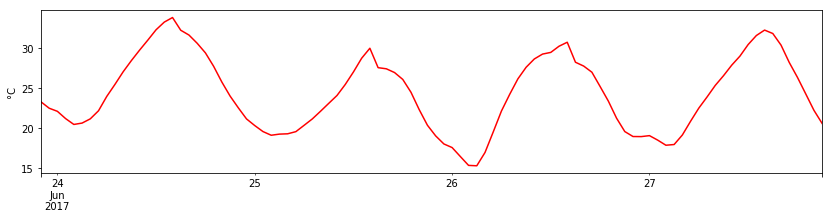

In [172]:
data['temperature'].plot(figsize=(14, 3), color='r' );  plt.ylabel('°C');

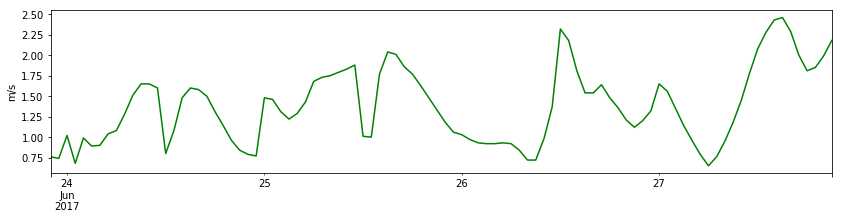

In [173]:
data['windSpeed'].plot(figsize=(14, 3), color='g' ); plt.ylabel('m/s');

### Irradiation solaire

In [163]:
def buildfluxdataframe(dateindex, cloudCover, coords, sigma, phi_C):
    df = [ sun.get_flux_surface( coords, d, sigma, phi_C ) \
                 for d in dateindex ]*( 1 - cloudCover )
    
    return df

In [165]:
sigma = 37  # deg, angle du toit coté bastille
phi_C_bastille = 50  # deg, azimuth du toit
phi_C_vercors = 50+180  # deg, azimuth du toit


data['Flux_bastille'] = buildfluxdataframe(data.index, data['cloudCover'], \
                                           coords_grenoble, sigma, phi_C_bastille)


data['Flux_vercors'] = buildfluxdataframe(data.index, data['cloudCover'], \
                                           coords_grenoble, sigma, phi_C_vercors)


/home/etienne/Projets/thermique_appart/py3/lib/python3.5/site-packages/pysolar/time.py:105: UserWarning: I don't know about leap seconds after 2015
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


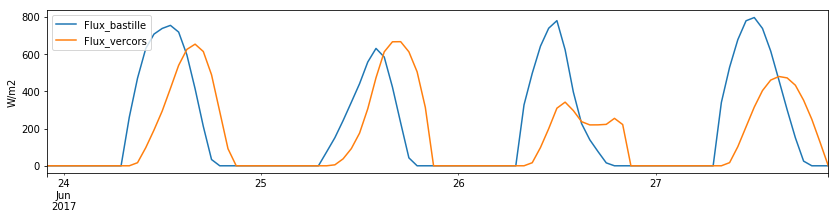

In [166]:
data[['Flux_bastille', 'Flux_vercors']].plot(figsize=(14, 3) )
plt.ylabel('W/m2');

## Grandeurs physiques

In [175]:
def coef_echange( vitesse_vent ):
    # vitesse_vent: m/s
    
    k = 0.0262 # W/m/K, conductivité thermique
    nu = 1.57e-5 #  m2.s−1 , viscosité cinématique air
    Pr = 0.708 # Prandl
    
    L = 4 # m, taille caractéristique, toit ou tuile ?
    
    Reynolds = vitesse_vent*L/nu
    
    if Reynolds > 5e3:
        # convection forcée, turbulent, Pr < 50  (cf. page 15)
        h = k/L * 0.036 *  Reynolds**(4/5) * Pr**(1/3)
    else:
        # convection naturelle
        h = 5
    
    return h

In [176]:
coef_echange( 2 )

7.732272559314057

In [125]:
albedo_tuile = 0.36  # Coef de reflexion tuiles

## Modèle SANS rayonement

In [227]:
# Coefficient d'échange pour la convection: 
h = data['windSpeed'].apply(coef_echange)

In [186]:
# Modèle :
Ttuile = {}
Ttuile['bastille'] = data['temperature'] + (1-albedo_tuile)*data['Flux_bastille']/h
Ttuile['vercors'] = data['temperature']  + (1-albedo_tuile)*data['Flux_vercors']/h


Ttuile = pd.DataFrame(Ttuile)

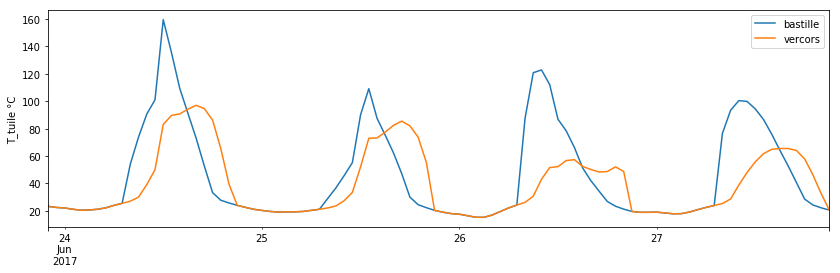

In [187]:
Ttuile.plot(figsize=(14, 4) ); plt.ylabel('T_tuile °C');

## Modèle avec le rayonement du toit

In [218]:
sigmaSB = 5.670373e-8 # Constante de Stefan-Boltzmann,   W.m-2.K-4

In [142]:
from scipy.optimize import brentq

In [219]:
def model02_apply( datarow, colflux=None  ):
    flux_soleil = datarow[ colflux ]
    T_air = datarow['temperature']
    h = coef_echange( datarow['windSpeed'] )


    rayonement_soleil = (1-albedo_tuile)*flux_soleil
    convection = lambda T: -h * (T - T_air)
    rayonement_toit = lambda T: -sigmaSB*( T + 273 )**4
    rayonement_ciel =  +sigmaSB*( T_air + 273 )**4  # insert cloud cover here
    
    somme_flux = lambda T: convection(T) + rayonement_toit(T) + rayonement_soleil + rayonement_ciel
    
    Tmin, Tmax = -50, 200
    T_eq = brentq(somme_flux, Tmin, Tmax)
    
    return T_eq

In [220]:
Ttuile = data.apply(model02_apply, axis=1, colflux='Flux_bastille')

In [221]:
Ttuile = {}
Ttuile['bastille'] = data.apply(model02_apply, axis=1, colflux='Flux_bastille')
Ttuile['vercors'] = data.apply(model02_apply, axis=1, colflux='Flux_vercors')

Ttuile = pd.DataFrame(Ttuile)

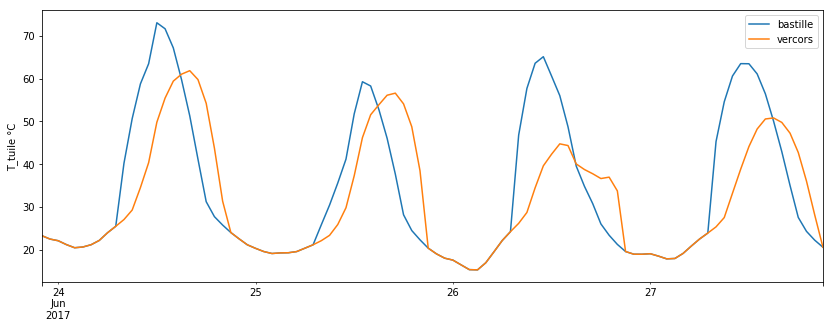

In [226]:
Ttuile.plot(figsize=(14, 5) ); plt.ylabel('T_tuile °C');

In [223]:
# Zoom
zoom_start = pd.to_datetime( '27/06/2017' ) 
mask = (allweatherdata.index > zoom_start)

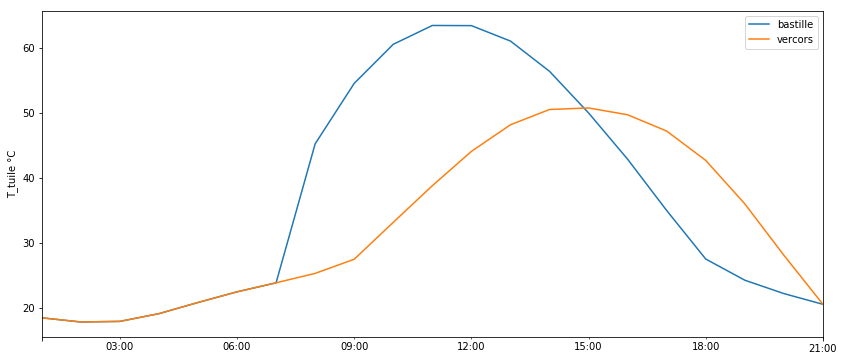

In [225]:
Ttuile.loc[mask].plot(figsize=(14, 6) ); plt.ylabel('T_tuile °C');

### Remarques
- Prise en compte de la pluie ... ?
- Effet des velux ?
- Pour le mur vertical ? 